In [1]:
import rxmc

Using database version X4-2024-12-31 located in: /home/beyerk/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [2]:
from collections import OrderedDict

import corner
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

## define parameters

In [3]:
params = [
    rxmc.params.Parameter("b", float, "[y-units]"),
    rxmc.params.Parameter("m", float, "[no-units]"),
]

## make the model

In [4]:
class LinearModel(rxmc.model.Model):
    def __call__(self, params: OrderedDict):
        return params["m"] * self.x + params["b"]

In [5]:
x = np.linspace(0, 1, 10)

In [6]:
my_model = LinearModel(x)

## define a prior

In [7]:
prior_mean = OrderedDict(
    [
        ("m", 1),
        ("b", 1),
    ]
)
prior_std_dev = OrderedDict(
    [
        ("m", 0.1),
        ("b", 0.3),
    ]
)

In [8]:
covariance = np.diag(list(prior_std_dev.values())) ** 2
mean = np.array(list(prior_mean.values()))

In [51]:
n_prior_samples = 10000
prior_distribution = stats.multivariate_normal(mean, covariance)
prior_samples = prior_distribution.rvs(size=n_prior_samples)

In [54]:
y = np.zeros((n_prior_samples, len(my_model.x)))
for i in range(n_prior_samples):
    sample = prior_samples[i, :]
    y[i, :] = my_model(rxmc.params.to_ordered_dict(sample, [p.name for p in params]))

upper, lower = np.percentile(y, [5, 95],  axis=0)

Text(0.5, 1.0, 'prior')

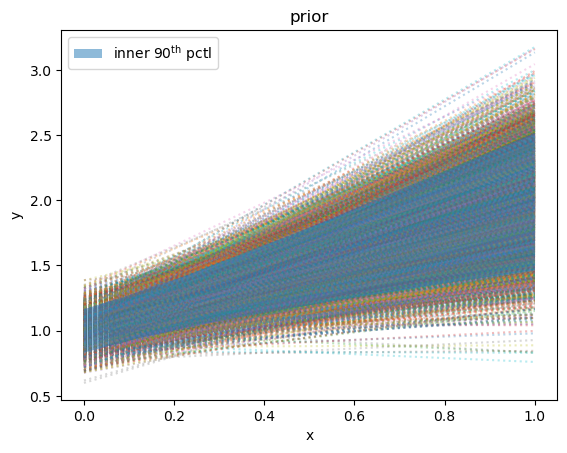

In [59]:
for i in range(n_prior_samples):
   plt.plot(my_model.x, y[i, :],":", zorder=1, alpha=0.3)
    #pass

plt.fill_between(my_model.x, lower, upper, alpha=0.5, zorder=2, label=r"inner 90$^\text{th}$ pctl")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("prior")

Text(0.5, 0.98, 'prior')

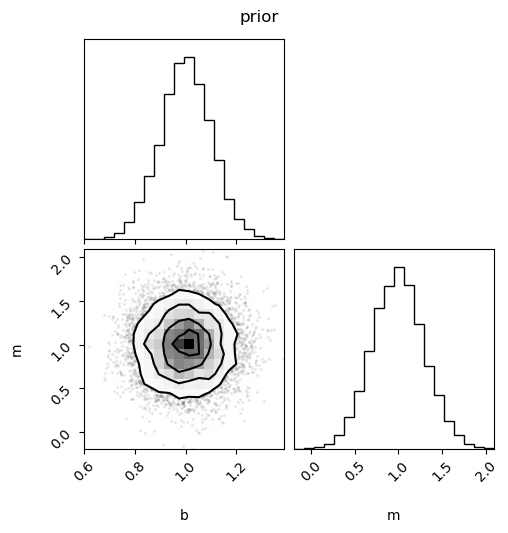

In [56]:
fig = corner.corner(prior_samples, labels=[p.name for p in params])
fig.suptitle("prior")

## find some data
In our case we will synthetically generate some data with noise about a "true" `m` and `b`. Our calibration posterior should converge to be centered about this true point.

Let us assume that the experimentalists made a perfect estimate of the experimental noise in their setup. That is, the error bars they report will correspond exactly to the true distribution from which we sample.

This noise will correspond to statistical noise. Later on we will look at systematic experimental error.

In [57]:
rng = np.random.default_rng(13)

Text(0.5, 1.0, 'experimental constraint')

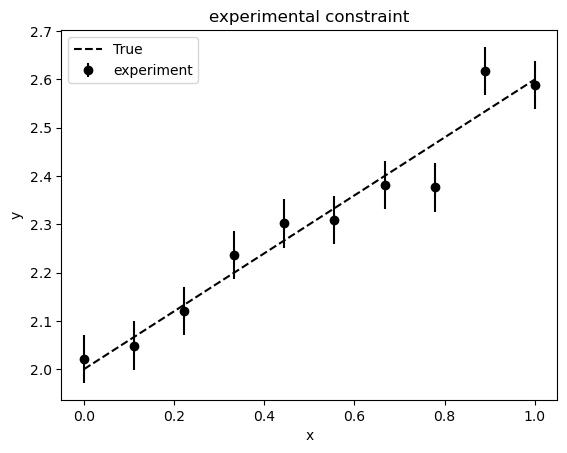

In [60]:
true_params = OrderedDict(
    [
        ("m", 0.6),
        ("b", 2),
    ]
)

noise = 0.05
y_exp = my_model(true_params) + rng.normal(scale=noise, size=len(my_model.x))
y_exp_err = noise * np.ones_like(y_exp) # noise is just a constant fraction of y
plt.errorbar(
    my_model.x,
    y_exp,
    y_exp_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment",
)
plt.plot(my_model.x, my_model(true_params), "k--", label=True)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("experimental constraint")

## set up constraint

In [61]:
constraint = rxmc.constraint.FixedCovarianceConstraint(
    y_exp,
    np.diag(y_exp_err**2),
    my_model,
)

## What is the reduced $\chi^2$ for the prior mean?

In [62]:
constraint.chi2(
    rxmc.params.to_ordered_dict(prior_distribution.mean, [p.name for p in params])
) / constraint.n_data_pts

np.float64(263.7787813398505)

In [63]:
constraint.log_det

np.float64(-59.914645471079815)

In [64]:
np.log((noise**2) ** constraint.n_data_pts)

np.float64(-59.914645471079815)

## running the calibration

In [68]:
help(rxmc.mcmc.run_chain)

Help on function run_chain in module rxmc.mcmc:

run_chain(prior, corpus: rxmc.corpus.Corpus, nsteps: int, batch_size: int, burnin: int, seed: int, rank: int = 0, proposal_cov_scale_factor: float = 1000, verbose: bool = True, output: pathlib.Path = None)
    Runs the MCMC chain with the specified parameters.
    
    Parameters:
        prior (object): The prior distribution object with mean, cov attributes
            and a logpdf method.
        corpus (corpus.Corpus): The corpus object with a logpdf method.
        nsteps (int): Total number of steps for the MCMC chain.
        batch_size (int): Number of steps per batch.
        burnin (int): Number of initial steps to discard.
        seed (int): Random seed for generating random numbers.
        rank (int): MPI rank for the current process.
        proposal_cov_scale_factor (float): Scale factor for the proposal
            covariance.
        verbose (bool): Flag to print extra logging information.
        output (Path, optional

In [ ]:
rxmc.mcmc.run_chain(100000, )

## Handling systematic bias

Text(0.5, 1.0, 'experimental constraint with bias')

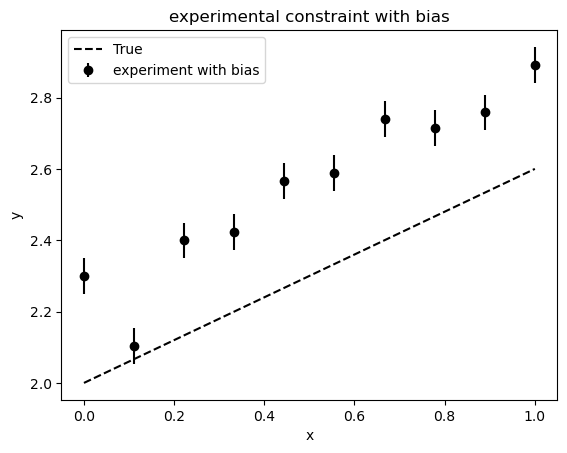

In [19]:
systematic_fractional_err = 0.1
y_exp_with_sys = y_exp * (1.0 + systematic_fractional_err)
plt.errorbar(
    my_model.x,
    y_exp_with_sys,
    y_exp_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment with bias",
)
plt.plot(my_model.x, my_model(true_params), "k--", label=True)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("experimental constraint with bias")

In [20]:
constraint = rxmc.constraint.FixedCovarianceConstraint(
    y_exp_with_sys,
    np.diag(y_exp_err**2) + systematic_fractional_err * np.outer(y_exp, y_exp),
    my_model,
)

In [21]:
x0 = rxmc.params.to_ordered_dict(prior_distribution.mean, [p.name for p in params])
constraint.chi2(x0) / constraint.n_data_pts

np.float64(15.553270937608795)

In [22]:
ym = constraint.model(x0)
chi2, log = rxmc.constraint.mahalanobis_distance_cholesky(
    constraint.y, ym, constraint.covariance
)
chi2 / constraint.n_data_pts

np.float64(15.553270937608929)

In [23]:
constraint.log_det

np.float64(-52.23410491733436)

In [24]:
log

np.float64(-52.23410491733431)